# Assignment 5: Classical Monte Carlo simulation of a liquid-solid transition

The objective of this exercise is to simulate the liquid-solid transition of a two-dimensional system using a Lennard-Jones interaction potential.

$$
    U_{LJ}(r) = 4\varepsilon\Biggl[\biggl(\frac{\sigma}{r}\biggr)^{12}-\biggl(\frac{\sigma}{r}\biggr)^6\Biggr]
$$

where $r$ is the distance between two interacting particles, $\sigma$ is known as the "radius" of the particle and $\varepsilon$ the typical energy of the potential. The total energy of a particular configuration is given by

$$
    \frac{E}{N} = \frac{2}{2}k_BT + \frac{1}{N}\biggl\langle\sum_{i=1}^N\sum_{j>1}^NU(r_{ij})\biggr\rangle
$$
The first term comes from the fact that every degree of freedom contributes $\frac{1}{2}k_BT$ to the energy of a particle, and we are in 2D.

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from tqdm import tqdm

### Class definition

We will use a class object for our particle ensemble since it is the easiest way to define a set of functions that share arguments and reference each other.

In [2]:
class Argon:
    def __init__(self,N,positions=[],density=0.96,T=3.0):
        # Generate x,y coordinates in a [0,L]x[0xL] box, density is rho = N/L^2, L = sqrt(N/rho)
        L = np.sqrt(N/density)
        if len(positions) == 0:
            self.positions = L*np.random.rand(N,2)
        else:
            self.positions = dc(positions)
        self.num_particles = N
        self.L = L
        self.T = T
        self.rho = density
        self.printValues(self.positions)

    def printValues(self,positions):
        # Plot current configuration
        plt.scatter(positions[:,0],positions[:,1],marker='o')
        plt.title("Argon ensemble configuration")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis([0,self.L,0,self.L])
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
    
    def distances(self,positions):
        N = self.num_particles
        dist_matrix = np.zeros((N, N))

        # Calculate pairwise differences in coordinates
        dx = positions[:, 0][:, np.newaxis] - positions[:, 0][np.newaxis, :]
        dy = positions[:, 1][:, np.newaxis] - positions[:, 1][np.newaxis, :]

        # Apply periodic boundary conditions
        dx = dx - self.L * np.round(dx / self.L)
        dy = dy - self.L * np.round(dy / self.L)

        # Calculate distances
        dist_matrix = np.sqrt(dx**2 + dy**2)

        return dist_matrix
    
    def distance_idx(self,positions,distances,i):
        # Re-calculate distances that changed due to particle i
        new_distances = dc(distances)
        for j in range(self.num_particles):
            dx = positions[i,0] - positions[j,0]
            dy = positions[i,1] - positions[j,1]
            
            # Apply periodic boundary conditions
            dx = dx - self.L * np.round(dx / self.L)
            dy = dy - self.L * np.round(dy / self.L)
            
            new_distances[i,j] = np.sqrt(dx**2 + dy**2)
            new_distances[j,i] = new_distances[i,j]
        return new_distances
    
    def energy_idx(self,distances,i,eps=1.0,sigma=1.0):
        # Lennard Jones potential
        energy = 0.0
        
        for j in range(self.num_particles):
            if j == i:
                continue
            r = distances[i,j]
            energy += 4*eps*((sigma/r)**12 - (sigma/r)**6)
        return energy/self.num_particles
    
    def energy(self,distances,eps=1.0,sigma=1.0):
        # Lennard Jones potential
        energy = 0.0

        # Calculate distances
        #distances = self.distances(positions)
        
        for i in range(self.num_particles):
            # For i < j to avoid double counting
            for j in range(i+1,self.num_particles):
                r = distances[i,j]
                energy += 4*eps*((sigma/r)**12 - (sigma/r)**6)

        # Chemical energy(?)
        energy += 1.5*self.num_particles*self.T
        
        return energy/self.num_particles
        
    def densityParticles(self,distances,dr=0.01):
        # Maximum distance will be L/sqrt(2) (but we normalize by the circle of radius L/2, 
        # so we only count up to L/2)
        rmax = self.L/np.sqrt(2)
        Nbins = int(rmax/dr)+1
        
        # Create empty array to count particles at each distance
        count_distances = np.zeros(Nbins)
        
        for particle_i in range(self.num_particles):
            for particle_j in range(particle_i+1,self.num_particles):                
                # Get distance between particles
                dist = distances[particle_i,particle_j]
                
                # Calculate bin index
                bin_idx = int(dist/dr)
                
                # Add count to both particles to that bin
                count_distances[bin_idx] += 2

        # Normalize counts of distances
        count_distances /= self.num_particles

        # Plot the density
        rmax = self.L/2
        Nbins = int(rmax/dr)+1

        r_vec = np.arange(1,Nbins)*dr
        area = 2*np.pi*r_vec*dr
        count_density = count_distances[0:Nbins-1]/(self.rho*area)
        
        return count_density

    def simulatedAnnealing(self,N_iter=100,cooldown=1.0,dt=0.1,dr=0.01,binning=(1.0,1)):
        # Calculate initial energy
        current_distances = dc(self.distances(self.positions))
        current_energy = dc(self.energy(current_distances))
        best_energy = np.inf
        best_solution = dc(self.positions)
        
        # Save energies at each iteration
        self.energies = np.zeros(N_iter)
        
        # Keep track of acceptance rate
        accepted = 0
        
        # Save count bins for final g(r) plot
        Nbins = int(self.L/2/dr) + 1
        count_density = np.zeros(Nbins-1)
        num_bins = 0
        
        T = self.T
        if cooldown < 1:
            scale = max(dt,np.sqrt(T))
        else:
            scale = dt

        for epoch in tqdm(range(N_iter)):
            # Choose particle to move
            idx = np.random.randint(0,self.num_particles)
            
            # Generate new solution (and check that it is not out of bounds)
            new_solution = dc(self.positions)
            new_solution[idx,:] += np.random.randn(2)*scale
            new_solution %= self.L
            
            # Calculate difference in energies
            new_distances = self.distance_idx(new_solution,current_distances,idx)
            delta_energy = self.energy_idx(new_distances,idx) - self.energy_idx(current_distances,idx)
            
            # Accept new solution based on the acceptance probability (or its logarithm)
            if delta_energy < 0 or np.exp(-delta_energy/T)+np.random.rand() > 1:
                self.positions = dc(new_solution)
                current_distances = dc(new_distances)
                current_energy += delta_energy
                accepted += 1
    
            # Keep track of best solution
            if current_energy < best_energy:
                best_energy = dc(current_energy)
                best_solution = dc(self.positions)
                
            # Cooldown
            T *= cooldown
            
            # Scale factor with temperature
            if cooldown < 1:
                scale = max(dt,np.sqrt(T))
            
            # Append energies
            self.energies[epoch] = current_energy
            
            # Calculate number of counts according to binning parameters:
            # binning = (threshold,self_correlation)
            #   - threshold means up to which percentage of the total iterations
            #     should we wait before we start calculating g(r)
            #   - self_correlation means how many iterations should we wait
            #     between successive calculations of g(r)
            if (epoch + 1) >= N_iter*binning[0] and (epoch + 1) % binning[1] == 0:
                count_density += self.densityParticles(current_distances,dr)
                num_bins += 1
    
        # Acceptance rate
        print("Acceptance rate: ",accepted/N_iter)
        
        self.printValues(self.positions)    
        return best_solution, count_density/num_bins

## Part 1:

Develop a Monte Carlo code for a (N,V,T) ensemble for a Lennard-Jones (LJ) system in two dimensions. Use $N = 242$ atoms.

Run an annealing simulation for Argon at density $\rho^* = 0.96$ in a square box of size $L\times L$. Use an annealing method to obtain the particle configuration having minimal energy. Physically, this configuration corresponds to a perfectly crystalline lattice.

The volume of the ensemble is calculated from the number of particles and the particle density of the system. Using the fact that the unit cell corresponds to a square box of size $L\times L$, the volume is precisely $L^2$ and thus, the length of this box is determined by the density of particles:

$$
    \rho^* = \frac{N}{V} = \frac{N}{L^2} \longrightarrow L = \sqrt{\frac{N}{\rho^*}}
$$

This first case we are assuming the system is at $T^* = 0$, and we expect the ground state to correspond to the perfectly crystalline lattice.

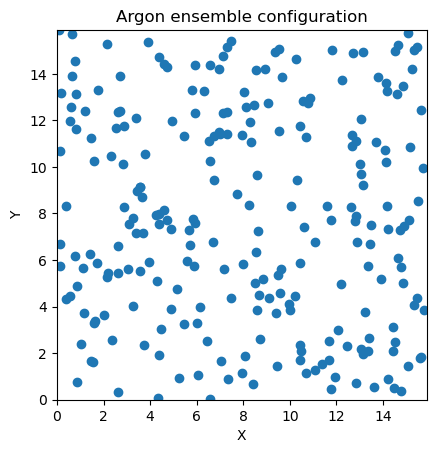

Initial energy: 1.0911739713511435e+24


100%|█████████████████████████████████████████████████████████████████████████| 300000/300000 [13:17<00:00, 376.19it/s]


Acceptance rate:  0.19804666666666668


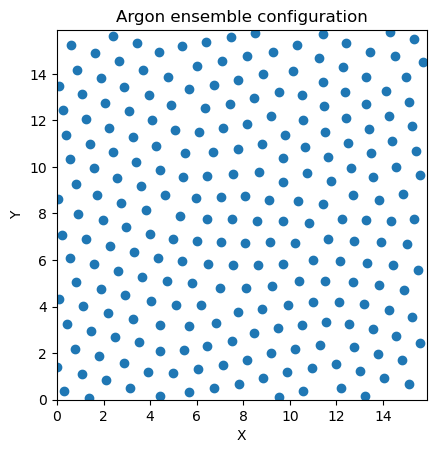

Final energy: 2.0343590595903525


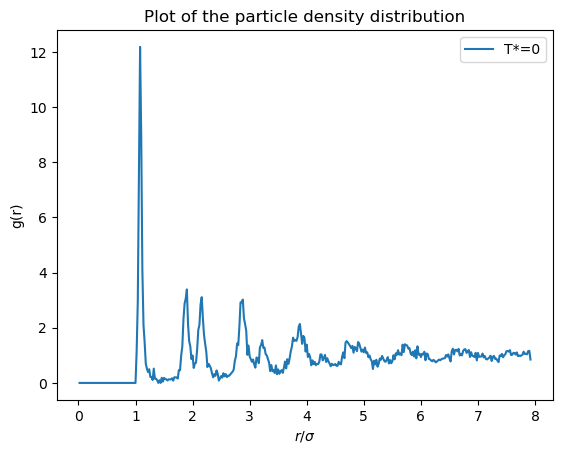

In [3]:
np.random.seed(7)

N = 242
rho = 0.96
# eps = 119.8/kB [J], sigma = 3.405 [A]

# Number of iterations
N_iter = 300000

# Initial system temperature
T = 10.0
dt = 0.004
dr = 0.02

# Initialize the ensemble
crystal = Argon(N,density=rho,T=T)
print("Initial energy:",crystal.energy(crystal.distances(crystal.positions)))
# Find the best configuration using simulated annealing
crystal_best_solution, crystal_density = crystal.simulatedAnnealing(N_iter=N_iter,cooldown=0.999,dt=dt,dr=dr)
print("Final energy:",crystal.energy(crystal.distances(crystal_best_solution)) - crystal.T)

# Plot the density
rmax = crystal.L/2
Nbins = int(rmax/dr)+1

# Plot g(r)
r_vec = np.arange(1,Nbins)*dr

plt.plot(r_vec,crystal_density,label=f'T*=0')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"g(r)")
plt.title(f'Plot of the particle density distribution')
plt.legend()
plt.show()

## Part 2:

Starting from the previous crystalline structure, now raise the temperature to $T^*=0.5$ and run a MC simulation with fixed temperature.
Plot the particle density $g(r)$.

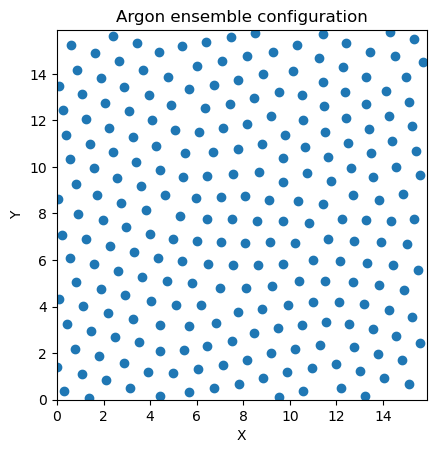

Initial energy: -2.2156409404096475


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.38it/s]


Acceptance rate:  0.7


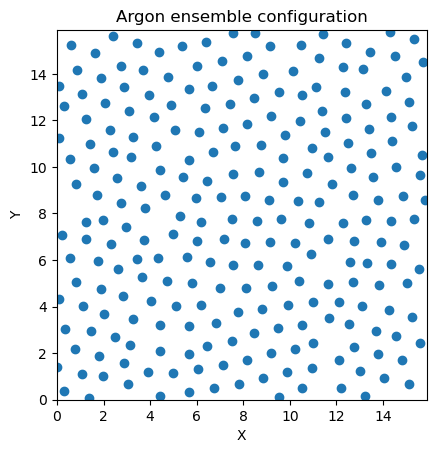

Final energy: 6.604971588058237


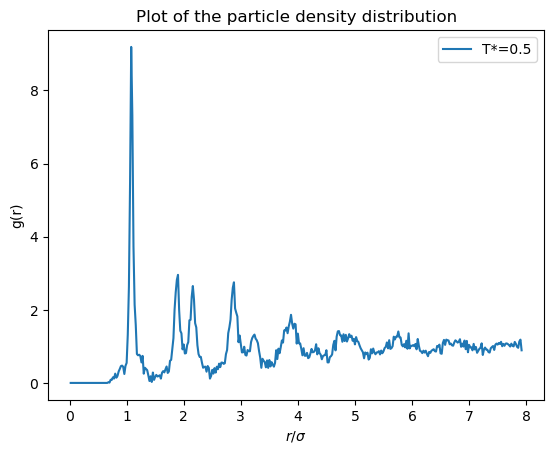

In [4]:
# System temperature
T = 0.5
dt = 0.2
dr = 0.02

# Number of iterations
N_iter = 100

# Initialize the ensemble with the crystalline lattice positions
a = Argon(N,positions=crystal_best_solution,density=rho,T=T)
print("Initial energy:",a.energy(a.distances(a.positions)))

# Find the best configuration using simulated annealing
a_best_solution, a_density = a.simulatedAnnealing(N_iter=N_iter,dt=dt,dr=dr,binning=(0.1,1))
print("Final energy:",a.energy(a.distances(a.positions)))

# Plot g(r)

plt.plot(r_vec,a_density,label=f'T*={a.T}')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"g(r)")
plt.title(f'Plot of the particle density distribution')
plt.legend()
plt.show()

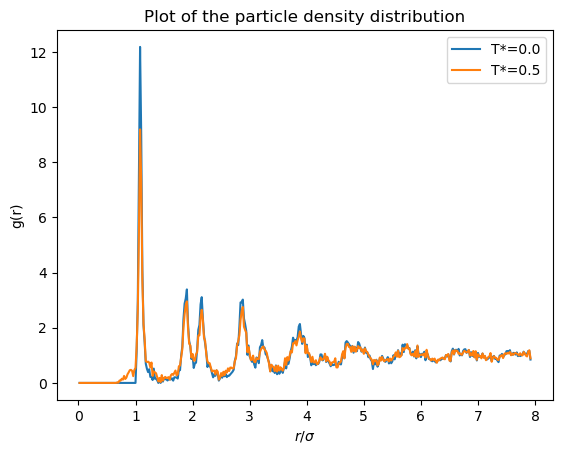

In [5]:
plt.plot(r_vec,crystal_density,label=f'T*={0.0}')
plt.plot(r_vec,a_density,label=f'T*={a.T}')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"g(r)")
plt.title(f'Plot of the particle density distribution')
plt.legend()
plt.show()

In [6]:
# Calculate standard deviation of the energies
std = (np.sum(a.energies**2)/N_iter - (np.sum(a.energies)/N_iter)**2)/np.sqrt(N_iter)

print("Standard deviation of the energy:",std)

Standard deviation of the energy: 0.32229165790516656


## Part 3:

From the crystalline structure, we now consider different values of the temperature and run a MC simulations with them. The particle density $g(r)$ is shown for the different temperatures.

### $T^* = 1.0$

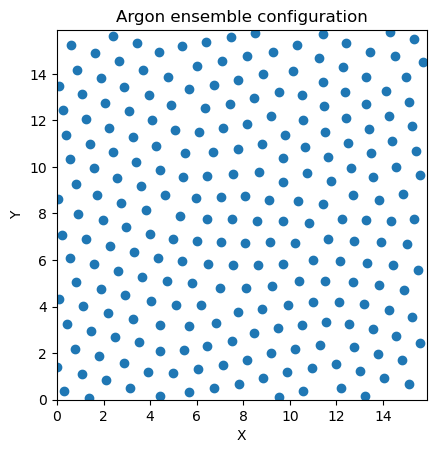

Initial energy: -1.4656409404096478


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.92it/s]


Acceptance rate:  0.71


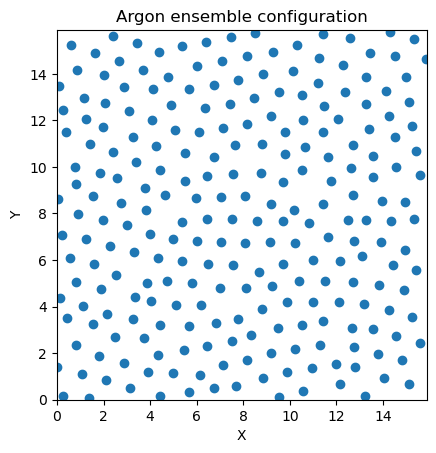

Final energy: 8.627382999202638
Standard deviation of the energy: 0.9736219048213786


In [7]:
# System temperature
T = 1.0
dt = 0.2
dr = 0.02

# Number of iterations
N_iter = 100

# Initialize the ensemble with the crystalline lattice positions
b = Argon(N,positions=crystal_best_solution,density=rho,T=T)
print("Initial energy:",b.energy(b.distances(b.positions)))

# Find the best configuration using simulated annealing
b_best_solution, b_density = b.simulatedAnnealing(N_iter=N_iter,dt=dt,dr=dr,binning=(0.1,1))
print("Final energy:",b.energy(b.distances(b.positions)))

# Calculate standard deviation of the energies
std = (np.sum(b.energies**2)/N_iter - (np.sum(b.energies)/N_iter)**2)/np.sqrt(N_iter)

print("Standard deviation of the energy:",std)

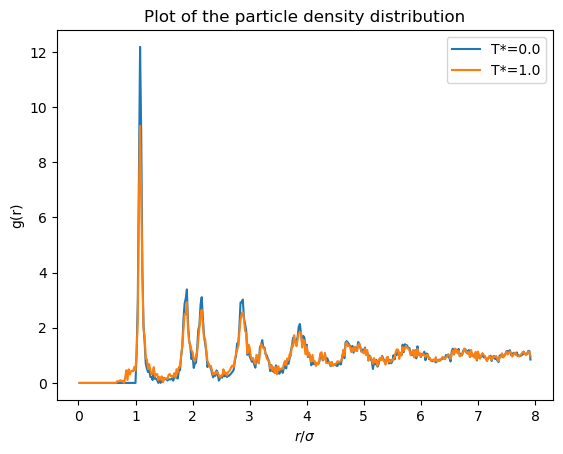

In [8]:
plt.plot(r_vec,crystal_density,label=f'T*={0.0}')
plt.plot(r_vec,b_density,label=f'T*={b.T}')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"g(r)")
plt.title(f'Plot of the particle density distribution')
plt.legend()
plt.show()

### $T^* = 1.5$

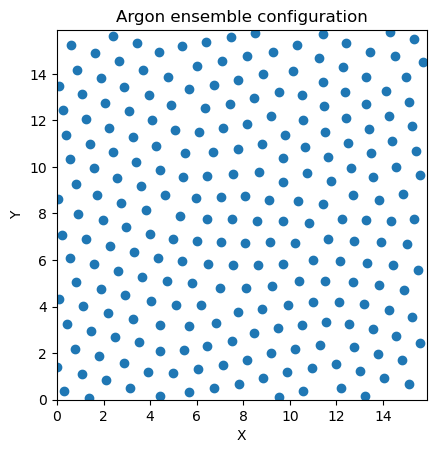

Initial energy: -0.7156409404096478


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.00it/s]


Acceptance rate:  0.8


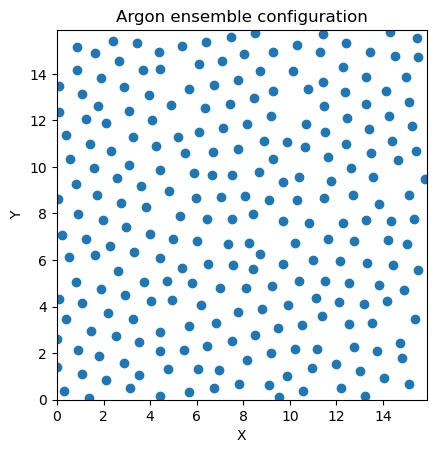

Final energy: 16.583546181715295
Standard deviation of the energy: 3.507610113844822


In [9]:
# System temperature
T = 1.5
dt = 0.2
dr = 0.02

# Number of iterations
N_iter = 100

# Initialize the ensemble with the crystalline lattice positions
c = Argon(N,positions=crystal_best_solution,density=rho,T=T)
print("Initial energy:",c.energy(c.distances(c.positions)))

# Find the best configuration using simulated annealing
c_best_solution, c_density = c.simulatedAnnealing(N_iter=N_iter,dt=dt,dr=dr,binning=(0.1,1))
print("Final energy:",c.energy(c.distances(c.positions)))

# Calculate standard deviation of the energies
std = (np.sum(c.energies**2)/N_iter - (np.sum(c.energies)/N_iter)**2)/np.sqrt(N_iter)

print("Standard deviation of the energy:",std)

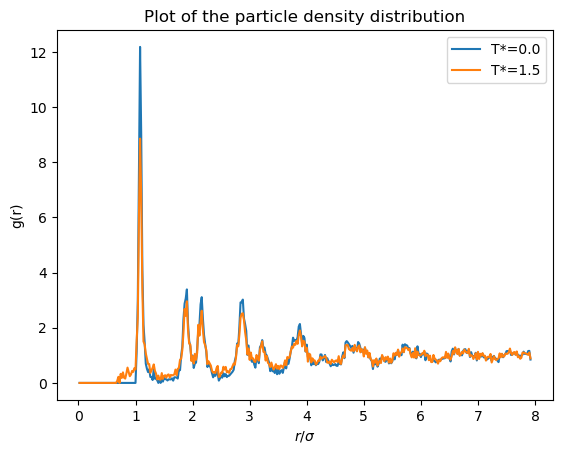

In [10]:
plt.plot(r_vec,crystal_density,label=f'T*={0.0}')
plt.plot(r_vec,c_density,label=f'T*={c.T}')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"g(r)")
plt.title(f'Plot of the particle density distribution')
plt.legend()
plt.show()

### $T^* = 2.0$

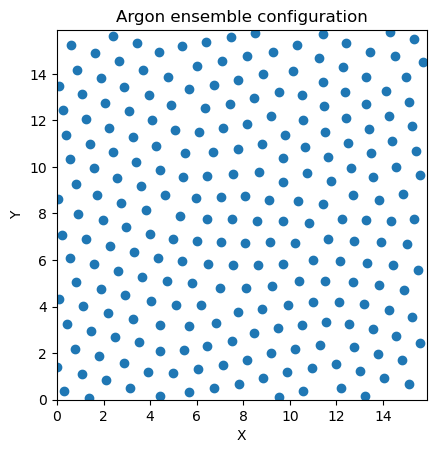

Initial energy: 0.034359059590352264


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.41it/s]

Acceptance rate:  0.77


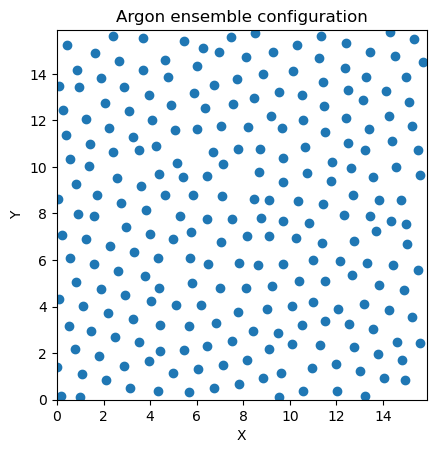

Final energy: 29.098578955470714
Standard deviation of the energy: 6.977996958246737


In [11]:
# System temperature
T = 2.0
dt = 0.25
dr = 0.02

# Number of iterations
N_iter = 100

# Initialize the ensemble with the crystalline lattice positions
d = Argon(N,positions=crystal_best_solution,density=rho,T=T)
print("Initial energy:",d.energy(d.distances(d.positions)))

# Find the best configuration using simulated annealing
d_best_solution, d_density = d.simulatedAnnealing(N_iter=N_iter,dt=dt,dr=dr,binning=(0.1,1))
print("Final energy:",d.energy(d.distances(d.positions)))

# Calculate standard deviation of the energies
std = (np.sum(d.energies**2)/N_iter - (np.sum(d.energies)/N_iter)**2)/np.sqrt(N_iter)

print("Standard deviation of the energy:",std)

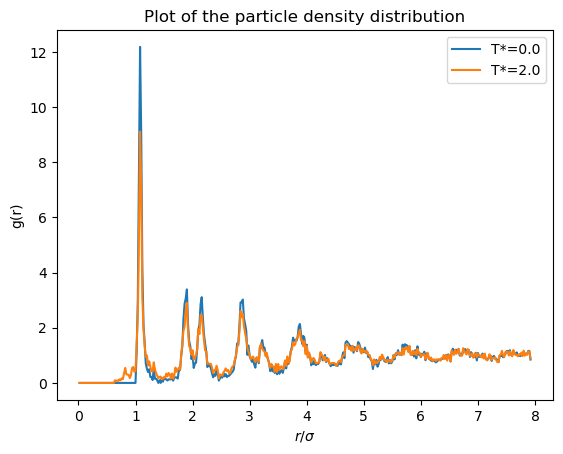

In [12]:
plt.plot(r_vec,crystal_density,label=f'T*={0.0}')
plt.plot(r_vec,d_density,label=f'T*={d.T}')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"g(r)")
plt.title(f'Plot of the particle density distribution')
plt.legend()
plt.show()

### $T^* = 2.5$

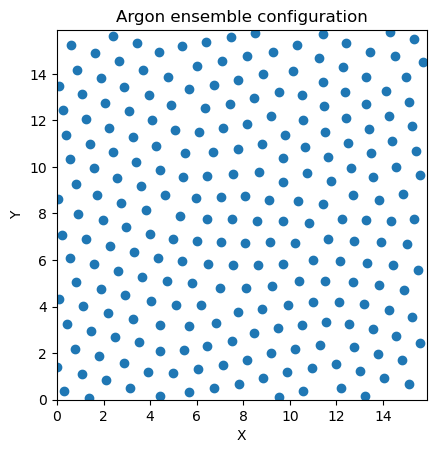

Initial energy: 0.7843590595903522


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.35it/s]


Acceptance rate:  0.59


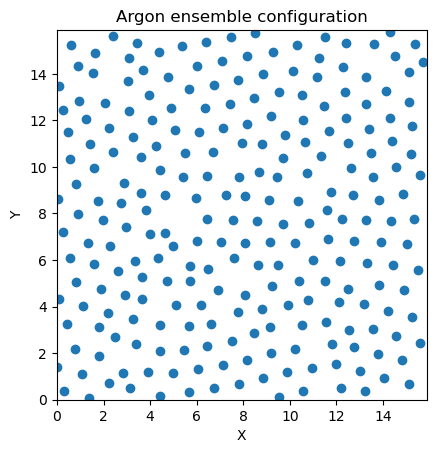

Final energy: 20.539048080942173
Standard deviation of the energy: 4.1018527831432365


In [13]:
# System temperature
T = 2.5
dt = 0.3
dr = 0.02

# Number of iterations
N_iter = 100

# Initialize the ensemble with the crystalline lattice positions
e = Argon(N,positions=crystal_best_solution,density=rho,T=T)
print("Initial energy:",e.energy(e.distances(e.positions)))

# Find the best configuration using simulated annealing
e_best_solution, e_density = e.simulatedAnnealing(N_iter=N_iter,dt=dt,dr=dr,binning=(0.1,1))
print("Final energy:",e.energy(e.distances(e.positions)))

# Calculate standard deviation of the energies
std = (np.sum(e.energies**2)/N_iter - (np.sum(e.energies)/N_iter)**2)/np.sqrt(N_iter)

print("Standard deviation of the energy:",std)

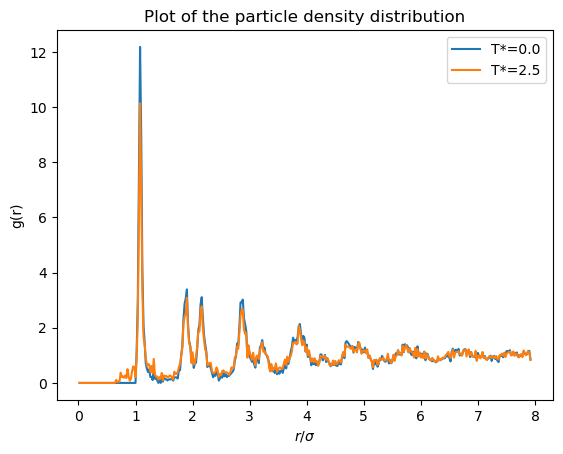

In [14]:
plt.plot(r_vec,crystal_density,label=f'T*={0.0}')
plt.plot(r_vec,e_density,label=f'T*={e.T}')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"g(r)")
plt.title(f'Plot of the particle density distribution')
plt.legend()
plt.show()

### $T^* = 3.0$

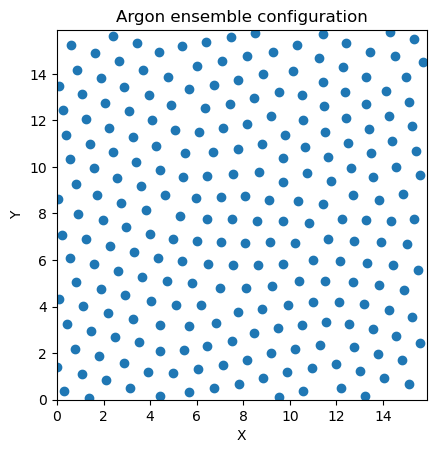

Initial energy: 1.5343590595903522


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.05it/s]


Acceptance rate:  0.552


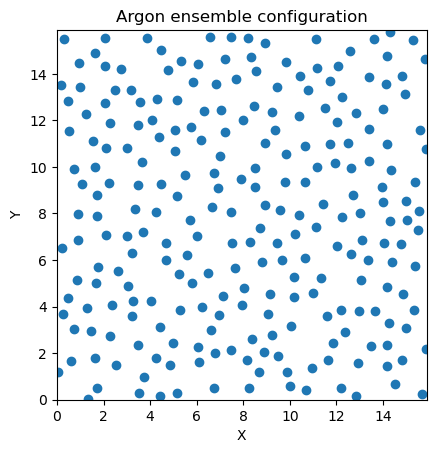

Final energy: 111.93029896219892
Standard deviation of the energy: 34.008887531622946


In [15]:
# System temperature
T = 3.0
dt = 0.3
dr = 0.02

# Number of iterations
N_iter = 1000

# Initialize the ensemble with the crystalline lattice positions
f = Argon(N,positions=crystal_best_solution,density=rho,T=T)
print("Initial energy:",f.energy(f.distances(f.positions)))

# Find the best configuration using simulated annealing
f_best_solution, f_density = f.simulatedAnnealing(N_iter=N_iter,dt=dt,dr=dr,binning=(0.1,1))
print("Final energy:",f.energy(f.distances(f.positions)))

# Calculate standard deviation of the energies
std = (np.sum(f.energies**2)/N_iter - (np.sum(f.energies)/N_iter)**2)/np.sqrt(N_iter)

print("Standard deviation of the energy:",std)

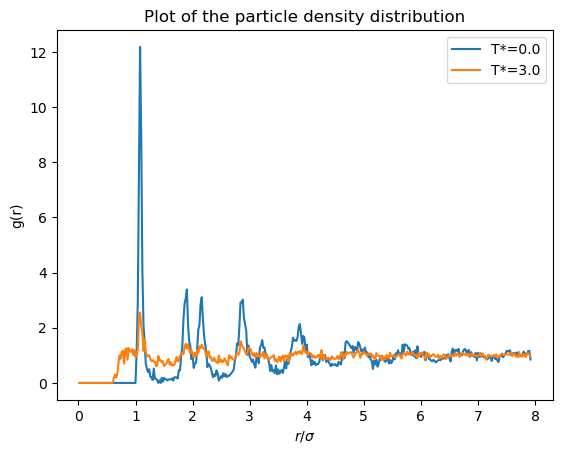

In [16]:
plt.plot(r_vec,crystal_density,label=f'T*={0.0}')
plt.plot(r_vec,f_density,label=f'T*={f.T}')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"g(r)")
plt.title(f'Plot of the particle density distribution')
plt.legend()
plt.show()

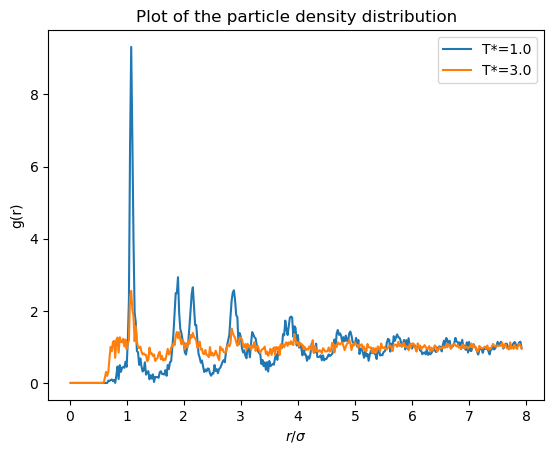

In [17]:
# Show the final g(r) plot with all the different temperatures
plt.plot(r_vec,b_density,label=f'T*={b.T}')
#plt.plot(r_vec,c_density,label=f'T*={c.T}')
#plt.plot(r_vec,d_density,label=f'T*={d.T}')
#plt.plot(r_vec,e_density,label=f'T*={e.T}')
plt.plot(r_vec,f_density,label=f'T*={f.T}')
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"g(r)")
plt.title(f'Plot of the particle density distribution')
plt.legend()
plt.show()